In [1]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
import cv2
import lightgbm
import os

In [289]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Import image

First we import our image, we totally have 1500 low resolution images and corresponding high resolution image

In [2]:
import glob

start = time.time()

LR = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB).astype(np.float32) for file in glob.glob("../data/train_set/LR/*.jpg")]
HR = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB).astype(np.float32) for file in glob.glob("../data/train_set/HR/*.jpg")]
end = time.time()
print('Time:',end - start)

Time: 22.89361596107483


###### Metric

We are going to use PSNR as our final measurement metric.

In [3]:
import math

def MSE(y_true,y_predict):
    temp = (y_true - y_predict)**2
    return sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])

def psnr(y_true,y_predict):
    temp = (y_true - y_predict)**2
    mse = sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])
    MAXI = 255
    return 20*math.log10(MAXI)-10*math.log10(mse)

###### Define basic parameters

We have 3 channels (RBG), and set seed and define the number of pixels taken from each picture to be our training data.

**RMK**

* We choose sample_size = 100 rather than 1000 because in the further research, we found that the result of 1000 pixels per image has similar PSNR with 100 pixels per image, but have significant improvement of speed. We will discuss it later.   

In [4]:
seed = 1000
channels = np.arange(3)
sample_size = 100
n_job = 16

### 1.1 Try OpenCV Function

We implement the *INTER_NEAREST* function in OpenCV to see the performance.

In [62]:
LR_original = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB) for file in glob.glob("./train_set/LR/*.jpg")]

LR_to_HR = [cv2.resize(lr, (lr.shape[1]*2, lr.shape[0]*2), interpolation = cv2.INTER_NEAREST) for lr in LR_original] 

In [63]:
start = time.time()

m = []
for i in np.arange(1500):
    m.append(psnr(HR[i],LR_to_HR[i]))

end = time.time()
print('psnr:',np.mean(m))
print('Time:',end - start)


psnr: 25.783482291479018
Time: 298.13437128067017


# 2. Preparation

<img src="../figs/Features.jpg">

### 2.1. Get Features X and respond y

We construct our features as follow:

1. Given a low resolution image, we padding the image first.
2. Pick n pixels (100) from each picture, for each point, we select surrouding 8 pixels as our features, and vectorize them.
3. Find the corresponding pixels(y) in high resolution image to each pixel that we randomly picked in low resolution image. (Remark: the index of corresponding y must be even, once we find the corresponding one in high resolution image (i.e the ith row and jth column), we pick HR[i,j],HR[i+1,j],HR[i,j+1],HR[i+1,j+1] as responds, where HR is hight resolution image.)
4. Centralize both X's and y's using the original picked pixel LR[i,j].
5. repeat 1-4 for 3 channels

In [5]:
# Get X and y for single pair of LR and HR
def get_X_and_y(LR,HR,n_sample = sample_size,seed = seed):
    # determine seed
    np.random.seed(seed)
    
    # Find neighbor
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])

    def get_neighbor_y(a,i,j):
        return([a[i,j],a[i+1,j],a[i,j+1],a[i+1,j+1]])
    
    # padding LR image
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    y1 = np.zeros((1*n_sample,4))
    y2 = np.zeros((1*n_sample,4))
    y3 = np.zeros((1*n_sample,4))
    
    X1 = np.zeros((1*n_sample,8))
    X2 = np.zeros((1*n_sample,8))
    X3 = np.zeros((1*n_sample,8))
    
    result = [X1,X2,X3]
    Y = [y1,y2,y3]
    
#     height = LR.shape[1]
#     width = LR.shape[0]
    width = LR.shape[1]
    height = LR.shape[0]
    
    # Random pick n_sample point per image
    pts_row = np.random.randint(1, height + 1,size = n_sample)
    pts_col = np.random.randint(1, width + 1,size = n_sample)
    
    for X,y,channel in zip(result,Y,channels):
        index = 0
        for i,j in zip(pts_row,pts_col):
            X_neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
            y_neigbor = get_neighbor_y(HR[:,:,channel],2*(i-1),2*(j-1))
            # Get X
            X[index] = X_neighbor - central
            # Get y
            y[index] = y_neigbor - central
            index +=1
    
    
    # Stack X&Y to 3d
    return np.dstack(result),np.dstack(Y)

def get_Whole_X_and_y(LR,HR,n_sample = sample_size,seed = seed):
    flag = 0
    for lr,hr in tqdm_notebook(zip(LR,HR)):
        if (flag == 0):
            X,y = get_X_and_y(lr,hr,n_sample,seed)
            flag = 1
        else:
            X_temp,y_temp = get_X_and_y(lr,hr,n_sample,seed)
            X = np.vstack([X,X_temp])
            y = np.vstack([y,y_temp])
    return X,y

### 2.2. Prediction (12 models)

We have 4 pixels to be predicted, as requested in the description. In our implementation, we provide two predictions. The first one is a combination of "fit" and "prediction", which correspond to use for "cross validation" and "grid search". We will talk about “grid search” later. The other one, which named "Predict_test" is used for predict the actual test data.

In [6]:
# test paramter == True means you want to predict X_test, False mean you want to predict X_train
# model_list = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model2,model3]
def Prediction(X_tr,y_tr,X_ts,model_list,test = True):
    
    if (test == False):
        X_test = X_tr
    else:
        X_test = X_ts
    
    prediction1 = np.zeros((X_test.shape[0],1,3))
    prediction2 = np.zeros((X_test.shape[0],1,3))
    prediction3 = np.zeros((X_test.shape[0],1,3))
    prediction4 = np.zeros((X_test.shape[0],1,3))
    
    predictions = [prediction1,prediction2,prediction3,prediction4]
    
    index = 0
    for channel in channels:
        for i,prediction in enumerate(predictions):
            model_list[index].fit(X_tr[:,:,channel],y_tr[:,i,channel].reshape(-1,1))
            prediction[:,:,channel] = model_list[index].predict(X_test[:,:,channel]).reshape(-1,1)
            index += 1
    return np.concatenate(predictions,axis = 1)


In [7]:
def fit_models(X_train,y_train,model_list):
    index = 0
    for channel in channels:
        for i in np.arange(4):
            model_list[index].fit(X_train[:,:,channel],y_train[:,i,channel].reshape(-1,1))
            index += 1

def Predict_test(X_test,model_list):
    prediction1 = np.zeros((X_test.shape[0],1,3))
    prediction2 = np.zeros((X_test.shape[0],1,3))
    prediction3 = np.zeros((X_test.shape[0],1,3))
    prediction4 = np.zeros((X_test.shape[0],1,3))
    
    predictions = [prediction1,prediction2,prediction3,prediction4]
    
    index = 0
    for channel in channels:
        for i,prediction in enumerate(predictions):
            prediction[:,:,channel] = model_list[index].predict(X_test[:,:,channel]).reshape(-1,1)
            index += 1
    return np.concatenate(predictions,axis = 1)

### 2.3. Cross Validation

<img src="../figs/CV.PNG">

We devide our data in n_folds (defalut 3), then iteratedly,use (n_folds - 1) folds as training set and the other fold as validation set, train the models and then predict value in the validation set.

In [8]:
from sklearn.model_selection import KFold

# Output testing error and training error
def cross_validation(X_train,y_train,model_list,metric,folds= 3):
    kf = KFold(n_splits=folds)
    val_error = []
    tr_error = []
    for train_index, val_index in tqdm_notebook(kf.split(X_train)):
        X_tr,y_tr = X_train[train_index],y_train[train_index]
        X_val,y_val = X_train[val_index],y_train[val_index]
        
        y_predict_val = Prediction(X_tr,y_tr,X_val,model_list,test = True)
        y_predict_tr = Prediction(X_tr,y_tr,X_val,model_list,test = False)
        # Metric 
        val_error.append(round(metric(y_val,y_predict_val),2)) # change metric here
        tr_error.append(round(metric(y_tr,y_predict_tr),2)) # change metric here
        
    return val_error,tr_error
        

### 2.4. Grid Search

Since we have to train 12 models, the GridSearchCV impletemented in sklearn won't work, thus we create a new grid search function to find the paramters corresponding to each model.

What we did is using for-loop to go through all 3 channels and 4 models per channel. Also, we can set the function to work parallelly to speed up

In [9]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def my_grid_search(X_train,y_train,model,parameters,cv = 3,n_jobs = n_job):
    
    
    reg = GridSearchCV(model,
                       cv=cv,
                      param_grid = parameters,
                       scoring = make_scorer(mean_squared_error,
                                        greater_is_better=False),
                      n_jobs = n_jobs)
    reg.fit(X_train, y_train)
    
    print('Best params',reg.best_params_)
    print('Best MSE:',-reg.score(X_train, y_train))
    
    return reg.best_params_

def grid_search_all_model(X_train,y_train,model,parameters,cv = 3):
    best_params = []
    index = 0
    for channel in channels:
        for i in np.arange(4):
            X_tr = X_train[:,:,channel]
            y_tr = y_train[:,i,channel]
            
            print('Model',index)
            model = model.fit(X_tr,y_tr)
            best_params.append(my_grid_search(X_tr,y_tr,model,parameters,cv = cv))
            index += 1
            
    return best_params

### 2.5. Super resolution

Here, given a picture, we firstly do the padding. Then, instead of randomply pick 100 points, we use all the points to construct features. Then, we implement our models to get y, which has ($dim_y = (height*weight) X 4$). To be more specific, every row has four points, which correspond to the lower resolution image's i-th pixel's super resolution value. Also, we need to add the central back.

In [10]:
def get_X_and_y_super_resolution(LR,HR):
    
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])

    def get_neighbor_y(a,i,j):
        return([a[i,j],a[i+1,j],a[i,j+1],a[i+1,j+1]])
    
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    height = LR.shape[1]
    width = LR.shape[0]
    height_HR = HR.shape[1]
    width_HR = HR.shape[0]
    
    y1 = np.zeros((height*width,4))
    y2 = np.zeros((height*width,4))
    y3 = np.zeros((height*width,4))
    
    X1 = np.zeros((height*width,8))
    X2 = np.zeros((height*width,8))
    X3 = np.zeros((height*width,8))
    
    result = [X1,X2,X3]
    Y = [y1,y2,y3]
    
    for X,y,channel in zip(result,Y,channels):
        index = 0
        for i,iy in zip(np.arange(1,width + 1),np.arange(0,width_HR,2)):
            for j,jy in zip(np.arange(1,height + 1),np.arange(0,height_HR,2)):
                # Get X neighbor
                neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
                # save central
                # Get y neighbor
                y_neigbor = get_neighbor_y(HR[:,:,channel],iy,jy)
                
                # Get X
                X[index] = neighbor - central
                # Get y
                y[index] = y_neigbor - central
                index +=1
    
    
    # Stack X&Y to 3d
    return np.dstack(result),np.dstack(Y)

def super_resolution(LR,HR,model_list):
    X,y = get_X_and_y_super_resolution(LR,HR)
    predict_y = Predict_test(X,model_list)
    
    c = LR.reshape(-1,3)
    # dim_y = (height*width) X 4
    height_HR = HR.shape[1]
    width_HR = HR.shape[0]
    
    picture = np.zeros(HR.shape)
    
    for channel in channels:
        index = 0 
        for i in np.arange(0,width_HR,2):
            for j in np.arange(0,height_HR,2):
                picture[i,j,channel] = predict_y[index,0,channel] + c[index,channel]
                picture[i+1,j,channel] = predict_y[index,1,channel] + c[index,channel]
                picture[i,j+1,channel] = predict_y[index,2,channel]+ c[index,channel]
                picture[i+1,j+1,channel] = predict_y[index,3,channel]+ c[index,channel]
                
                index += 1
    PSNR = psnr(y,predict_y)  
    
    return picture.astype(np.uint8),PSNR

def get_X_super_resolution(LR):
    
    def get_neighbor_X(a,i,j):
        return([a[i-1,j-1],a[i-1,j],a[i-1,j+1],a[i,j-1],a[i,j+1],a[i+1,j-1],a[i+1,j],a[i+1,j+1]],a[i,j])
    
    BLACK = [0, 0, 0]
    image_padding = cv2.copyMakeBorder(LR, 1 , 1, 1, 1, cv2.BORDER_CONSTANT, value=BLACK)
    
    height = LR.shape[1]
    width = LR.shape[0]
    
    X1 = np.zeros((height*width,8))
    X2 = np.zeros((height*width,8))
    X3 = np.zeros((height*width,8))
    
    result = [X1,X2,X3]
    
    for X,channel in zip(result,channels):
        index = 0
        for i in np.arange(1,width + 1):
            for j in np.arange(1,height + 1):
                # Get X neighbor
                neighbor,central = get_neighbor_X(image_padding[:,:,channel],i,j)
                # save central

                # Get X
                X[index] = neighbor - central
    
    # Stack X to 3d
    return np.dstack(result)

def super_resolution_LR(LR,model_list):
    X = get_X_super_resolution(LR)
    predict_y = Predict_test(X,model_list)
    
    c = LR.reshape(-1,3)
    # dim_y = (height*width) X 4
    height_HR = LR.shape[1] * 2
    width_HR = LR.shape[0] * 2
    
    picture = np.zeros((width_HR, height_HR, 3))
    
    for channel in channels:
        index = 0 
        for i in np.arange(0,width_HR,2):
            for j in np.arange(0,height_HR,2):
                picture[i,j,channel] = predict_y[index,0,channel] + c[index,channel]
                picture[i+1,j,channel] = predict_y[index,1,channel] + c[index,channel]
                picture[i,j+1,channel] = predict_y[index,2,channel]+ c[index,channel]
                picture[i+1,j+1,channel] = predict_y[index,3,channel]+ c[index,channel]
                
                index += 1        
                
    return picture.astype(np.uint8)

# 3. Prepare data

Get our features and responds

In [11]:
start = time.time()
X,y = get_Whole_X_and_y(LR,HR,n_sample = sample_size)
end = time.time()
print('Time:',end - start)


Time: 48.91805601119995


In [12]:
print(' X shape:',X.shape,'\n','y shape:',y.shape)

 X shape: (150000, 8, 3) 
 y shape: (150000, 4, 3)


### 3.1. Train & Test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = True ,random_state=seed)

In [14]:
print(' X_train shape:',X_train.shape,'\n','y_train shape:',y_train.shape)

 X_train shape: (120000, 8, 3) 
 y_train shape: (120000, 4, 3)


In [15]:
print(' X_test shape:',X_test.shape,'\n','y_test shape:',y_test.shape)

 X_test shape: (30000, 8, 3) 
 y_test shape: (30000, 4, 3)


# 4. Baseline model (gbm)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

### 4.1. Tuning models

###### 4.1.1. Grid Search

In [17]:
parameters_tunning = {
    'learning_rate':[0.01, 0.1, 0.2, 0.3], # tuning (started with higher learning rate), hight value --> overfit
    'min_samples_split' : [2, 5, 10], # tuning,high values --> under-fitting
    'min_samples_leaf' : [2, 4,8,10], # tuning, similar to min_samples_split
}

In [18]:
start = time.time()
best = grid_search_all_model(X_train,y_train,model,parameters_tunning,cv = 3)

end = time.time()
print('Time:',end - start)

Model 0
Best params {'learning_rate': 0.2, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best MSE: 148.95659474923593
Model 1
Best params {'learning_rate': 0.1, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best MSE: 149.9695441668164
Model 2
Best params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best MSE: 155.06416635649742
Model 3
Best params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best MSE: 150.561882053127
Model 4
Best params {'learning_rate': 0.2, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best MSE: 141.21947290195465
Model 5
Best params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best MSE: 143.65584948963195
Model 6
Best params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 5}
Best MSE: 147.99993570980564
Model 7
Best params {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best MSE: 143.84592645414705
Model 8
Best params {'learning_rate': 0.2, '

In [17]:
best = [{'learning_rate': 0.2, 'min_samples_leaf': 8, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 8, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.2, 'min_samples_leaf': 2, 'min_samples_split': 5},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 5},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 10},
 {'learning_rate': 0.2, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 4, 'min_samples_split': 5},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2},
 {'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 2}]

In [18]:
start = time.time()

model_list_gbm = []

for i in np.arange(12):
    model_list_gbm.append(GradientBoostingRegressor(**best[i],random_state = seed))

end = time.time()
print('Time:',end - start)

Time: 0.0009737014770507812


##### 4.1.2. Cross validation

In [22]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_gbm,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)


 Validation PSNR: [26.04, 26.2, 26.16] 
 Train PSNR: [26.47, 26.39, 26.41] 


Time: 272.263188123703


From the cross validation, we can know that our baseline method are not overfit, since the test PSNR are close to train PSNR.

### 4.2. Make Prediction

###### 4.2.1. Train models

In [19]:
start = time.time()

fit_models(X_train,y_train,model_list_gbm)

end = time.time()
print('Time:',end - start)

Time: 130.25535941123962


###### 4.2.2. Predict Test set

In [20]:
start = time.time()

prediction = Predict_test(X_test,model_list_gbm)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.10305467926151 


Time: 0.9045805931091309


# 5. Advanced algorithm (Xgboost)

In [134]:
from xgboost import XGBRegressor    

model = XGBRegressor(n_estimators = 100,
                     learning_rate = 0.1,
                      booster = 'gbtree',
                     min_child_weight = 6,
                     n_jobs = n_job,
                     eval_metric = 'rmse',
                     random_state = seed)

### 5.1. Tuning Model

##### 5.1.1 Grid Search

In [136]:
# start = time.time()

# from xgboost import XGBRegressor    

# start = time.time()

# model_list_xgb = []

# params_xgb_tuning = {
#               'subsample':[i/10.0 for i in range(6,11)],
#               'colsample_bytree':[i/10.0 for i in range(6,11)], 
#               'max_depth': [2,3,4,5]
#              }


# best_param = grid_search_all_model(X_train,y_train,model,params_xgb_tuning)

    
# end = time.time()
# print('Time:',end - start)

In [137]:
start = time.time()

model_list_xgb = []
for i in np.arange(12):
    model_list_xgb.append(XGBRegressor(learning_rate = 0.1,
                                       booster = 'gbtree',
                                       min_child_weight = 6,
                                        n_jobs = n_job,
                                        n_estimators = 100,
                                       subsample = 1,
                                       colsample_bytree = 0.8,
                                       max_depth = 5,
                                        random_state = seed))
    
end = time.time()
print('Time:',end - start)

Time: 0.0002613067626953125


##### 5.1.2. Cross Validation

In [138]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_xgb,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)


 Validation PSNR: [26.07, 26.23, 26.2] 
 Train PSNR: [26.92, 26.85, 26.88] 


Time: 75.56308078765869


### 5.2. Make Prediction

###### 5.2.1 Train models

In [196]:
start = time.time()

fit_models(X_train,y_train,model_list_xgb)

end = time.time()
print('Time:',end - start)

Time: 277.3800723552704


###### 5.2.2 Predict Test set

In [197]:
start = time.time()

prediction = Predict_test(X_test,model_list_xgb)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.039720724299634 


Time: 4.063607215881348


# 6. Advanced algorithm (Light GMB)

In [21]:
from lightgbm import LGBMRegressor

### 6.1. Tuning Model

##### 6.1.1. Grid Search

In [90]:
parameters_tunning = {
    'learning_rate':[0.01, 0.1, 0.2, 0.3], # tuning (started with higher learning rate), hight value --> overfit
    'min_child_samples' : [2, 4,8,10],
    'colsample_bytree': [i/10.0 for i in range(6,11)]} # tuning, similar to min_samples_samples

model = LGBMRegressor(n_jobs = n_job)

In [93]:
# start = time.time()
# best = grid_search_all_model(X_train,y_train,model,parameters_tunning,cv = 3)

# end = time.time()
# print('Time:',end - start)

In [23]:
model_list_lgb = []
for i in np.arange(12):
    model_list_lgb.append(lightgbm.LGBMModel(learning_rate = 0.05,
                                        n_jobs = n_job,
                                        n_estimators = 200,
                                        random_state = seed,
                                        min_data_in_leaf = 40,
                                        objective='regression'))

##### 6.1.2. Cross Validation

In [23]:
start = time.time()

# print(model_list_lgb[0])
val_error,tr_error = cross_validation(X_train,y_train,model_list_lgb,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)

KeyboardInterrupt: 

### 6.2. Make Prediction

###### 6.2.1 Train models

In [24]:
start = time.time()

fit_models(X_train,y_train,model_list_lgb)

end = time.time()
print('Time:',end - start)

Time: 19.83057188987732


###### 6.2.2 Predict Test set

In [25]:
start = time.time()

prediction = Predict_test(X_test,model_list_lgb)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.172132575193324 


Time: 3.1158692836761475


# 7. Advanced algorithm (Random Forest)

In [131]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()

### 7.1. Tuning Model

##### 7.1.1. Grid Search

In [132]:
parameters_rf = {
    'n_estimators':[30,50], # number of trees
    'min_samples_split' : [5, 10, 15], # minimum number of samples required to split a node
    'min_samples_leaf' : [4,8,12] # minumum number of samples required at each leaf node
}

In [133]:
start = time.time()
best_rf = grid_search_all_model(X_train,y_train,model_rf,parameters_rf,cv = 3)

end = time.time()
print('Time:',end - start)

Model 0
Best params {'min_samples_split': 5, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 111.90318899241801
Model 1
Best params {'min_samples_split': 15, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 109.75202331094341
Model 2
Best params {'min_samples_split': 10, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 113.04683253950004
Model 3
Best params {'min_samples_split': 15, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 110.0267683279919
Model 4
Best params {'min_samples_split': 10, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 107.6238266829209
Model 5
Best params {'min_samples_split': 5, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 104.81182284849491
Model 6
Best params {'min_samples_split': 15, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 108.04929922380353
Model 7
Best params {'min_samples_split': 15, 'min_samples_leaf': 12, 'n_estimators': 50}
Best MSE: 105.21240289117571
Model 8
Best params {'min_samples_split': 10, 'min_s

In [143]:
best_rf = [{'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 15, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 50},
 {'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 50}]

In [144]:
start = time.time()

model_list_rf = []

for i in np.arange(12):
    model_list_rf.append(RandomForestRegressor(**best_rf[i],random_state = seed,n_jobs = n_job))

end = time.time()
print('Time:',end - start)

Time: 0.00497126579284668


##### 7.1.2 Cross Validation

In [145]:
start = time.time()

val_error,tr_error = cross_validation(X_train,y_train,model_list_rf,psnr,folds= 3)
print(' Validation PSNR:',val_error,'\n','Train PSNR:',tr_error,'\n\n')

end = time.time()
print('Time:',end - start)


 Validation PSNR: [26.06, 26.22, 26.19] 
 Train PSNR: [27.72, 27.63, 27.65] 


Time: 140.64839267730713


### 7.2. Make Prediction

##### 7.2.1 Train models

In [236]:
start = time.time()

fit_models(X_train,y_train,model_list_rf)

end = time.time()
print('Time:',end - start)

Time: 34.490190505981445


##### 7.2.2 Predict Test set

In [237]:
start = time.time()

prediction = Predict_test(X_test,model_list_rf)
print('PSNR:',psnr(prediction, y_test),'\n\n')

end = time.time()
print('Time:',end - start)

PSNR: 26.20172578819789 


Time: 1.3583359718322754


# 8. Summary

In [240]:
# psnr: 25.783482291479018
# Time: 298.13437128067017
psnr_with_models = pd.DataFrame({'INTER_NEAREST': [25.78,np.nan ,298.13], 
                                 'GBM (n_sample = 100)': [26.14, 73.92,0.52],
                                 'Xgboost (n_sample = 100)':[26.19,19.13,0.28],
                                'GBM (n_sample = 1000)':[25.95,739.2,5.52],
                                'Xgboost (n_sample = 1000)':[26.03,277.5,4.06],
                                'Random Forest (n_sample = 100)': [26.20,33.69,1.36],
                                 'Light GBM (n_sample = 100)': [26.23,6.14,0.5],
                                 'Light GBM (n_sample = 1000)': [26.07,30.61,4.73]
                                },index = ['PSNR on Test','Train Time','Predict Time']).T

def color_best(val):
    
    best_performanace = psnr_with_models.agg({'PSNR on Test':np.max,'Train Time':np.min,'Predict Time':np.min})
    
    color = 'red' if val in best_performanace.tolist() else 'black'
    return 'color: %s' % color

table = psnr_with_models.style.applymap(color_best)
table

As we can see from the above table, we can conclude as foloowing:

* All of our advanced models get better performance compared to the baseline model as well as OpenCv implemented function.
* Light GBM has highest score and highest speed of train. 
* Xgboost has highest speed for prediction.
* When n_sample = 1000 rather than 100, our performance become worse since we are not tunning paramters for the reason that it consume to much time, however, from cross validation we can see it become more robust when our sample become larger.
* When sample size become larger, Xgboost become slower, however, light GBM still fast.

After balancing time consumption and PSNR score, we decide to choose model: Light GBM (n_sample = 100)

### 8.1 Super resolution 100 images with light gbm

In [251]:
start = time.time()

PSNR_list = []

for index in np.arange(100):
    _,PSNR = super_resolution(LR[index],HR[index],model_list_lgb)
    PSNR_list.append(PSNR)
    
print('PSNR is {:.3}'.format(np.mean(PSNR_list)))

end = time.time()
print('Time:',end - start)

PSNR is 28.1
Time: 551.9331457614899


### 8.2 Compare our result image with original high resolution image

<IPython.core.display.Javascript object>


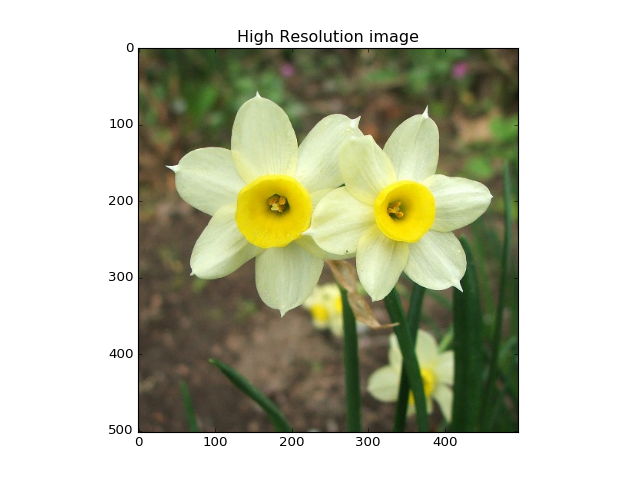

In [282]:
index = 7
model_list_best = model_list_lgb

picture = super_resolution_LR(LR[index],model_list_best)

plt.figure()
plt.imshow(HR[index].astype(np.uint8))
plt.title("High Resolution image")

<IPython.core.display.Javascript object>


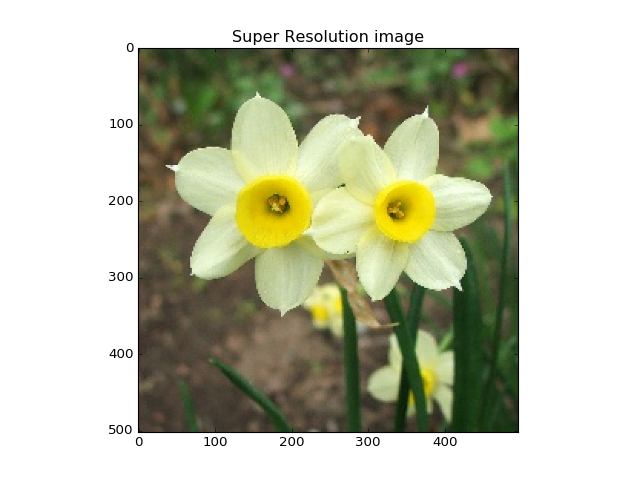

In [283]:
plt.figure()
plt.imshow(picture);
plt.title("Super Resolution image")

In [287]:
print("PSNR: ",psnr(HR[index],picture))

PSNR:  31.34139313405133


# 9. Super Resolution for Test LR Images

In [27]:
test_path = "../data/test_set/*.jpg"
save_path_B = "../figs/SR_B/"
save_path_I = "../figs/SR_I/"

def super_resolution_test(t_path, s_path,model_list):
    for file in glob.glob(t_path):
        name = file[-12::]
        LR = cv2.imread(file).astype(np.float32)
        picture= super_resolution_LR(LR,model_list) 
        cv2.imwrite(os.path.join(s_path , name), picture)
        cv2.waitKey(0)

In [28]:
start = time.time()

super_resolution_test(test_path, save_path_B,model_list_gbm)

end = time.time()
print('Time:',end - start)

Time: 64.94702672958374


In [29]:
start = time.time()

super_resolution_test(test_path, save_path_I,model_list_lgb)

end = time.time()
print('Time:',end - start)

Time: 95.643887758255
